# **Hypothesis Testing**

Joseph Lardie

September 2023

# **Imports**

In [1]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt
import plotly


# Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder

# Scipy
from scipy import stats
from scipy.stats import norm, pearsonr
import statsmodels.api as sm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

## **Loading in datasets**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Loading NYC Restaraunt Data
ydf = pd.read_csv('ydf')

In [4]:
# Restaurant Inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209141 entries, 0 to 209140
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  209141 non-null  int64  
 1   DBA                    208544 non-null  object 
 2   BORO                   209141 non-null  object 
 3   BUILDING               208824 non-null  object 
 4   STREET                 209135 non-null  object 
 5   ZIPCODE                206455 non-null  float64
 6   CUISINE DESCRIPTION    206702 non-null  object 
 7   INSPECTION DATE        209141 non-null  object 
 8   ACTION                 206702 non-null  object 
 9   VIOLATION CODE         205553 non-null  object 
 10  VIOLATION DESCRIPTION  205553 non-null  object 
 11  CRITICAL FLAG          209141 non-null  object 
 12  SCORE                  199209 non-null  float64
 13  GRADE                  102462 non-null  object 
 14  GRADE DATE             93826 non-nul

In [5]:
# Yelp Reviews data
ydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alias         847 non-null    object 
 1   name          847 non-null    object 
 2   image_url     847 non-null    object 
 3   url           847 non-null    object 
 4   review_count  847 non-null    int64  
 5   categories    847 non-null    object 
 6   rating        847 non-null    float64
 7   coordinates   847 non-null    object 
 8   transactions  847 non-null    object 
 9   location      847 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 66.3+ KB


# **Data Cleaning**

In [6]:
# Selecting subset of only restaurants from Brooklyn
brooklyndf = rdf[rdf['BORO'].str.lower() == 'brooklyn']

In [7]:
# Selecting subset of only restaurants in Brooklyn that have pizza in the cuisine description
pizza_brooklyn_subset = brooklyndf[(brooklyndf['CUISINE DESCRIPTION'].str.lower() == 'pizza')]

In [8]:
# Filtering out rows with NaN in the 'GRADE' column
pizza_brooklyn_subset = pizza_brooklyn_subset.dropna(subset=['GRADE'])

In [9]:
# Taking a look at Brooklyn pizza restaurants in inspection data
print(pizza_brooklyn_subset)

           CAMIS                                  DBA      BORO BUILDING  \
143     40574680                         PETE'S PLACE  Brooklyn     5620   
205     50131915                99 CENT SUPREME PIZZA  Brooklyn      297   
515     50037645                          JOE'S PIZZA  Brooklyn      216   
533     41459621  GINO'S BRICK OVEN PIZZA & TRATTORIA  Brooklyn   548550   
607     41273383                    LA BELLA PIZZERIA  Brooklyn     8509   
...          ...                                  ...       ...      ...   
208844  50099918                 JOE & SAL'S PIZZERIA  Brooklyn      353   
208855  50126709                           FINI PIZZA  Brooklyn      305   
208867  50035397                          DANNY PIZZA  Brooklyn     1620   
208871  41196869                          LAYLA JONES  Brooklyn      214   
208885  50102007               ROME TO BROOKLYN PIZZA  Brooklyn      755   

                 STREET  ZIPCODE CUISINE DESCRIPTION INSPECTION DATE  \
143            

In [10]:
# Making the names of the restaurants in both data sets compatable for the merge
column_name = 'name'
ydf['name'] = ydf['name'].apply(lambda x: str(x).upper())

In [11]:
# Merging the two data sets on the names of the restaurants 
merged_df = pd.merge(pizza_brooklyn_subset, ydf, left_on='DBA', right_on='name', how='inner', indicator=True)

# Displaying the merged dataframe
print("\nMerged DataFrame:")
print(merged_df)


Merged DataFrame:
        CAMIS                 DBA      BORO BUILDING          STREET  ZIPCODE  \
0    50037645         JOE'S PIZZA  Brooklyn      216  BEDFORD AVENUE  11249.0   
1    50037645         JOE'S PIZZA  Brooklyn      216  BEDFORD AVENUE  11249.0   
2    50037645         JOE'S PIZZA  Brooklyn      216  BEDFORD AVENUE  11249.0   
3    50037645         JOE'S PIZZA  Brooklyn      216  BEDFORD AVENUE  11249.0   
4    50037645         JOE'S PIZZA  Brooklyn      216  BEDFORD AVENUE  11249.0   
..        ...                 ...       ...      ...             ...      ...   
508  50134489  LITTLE ITALY PIZZA  Brooklyn      179  BEDFORD AVENUE  11211.0   
509  50134489  LITTLE ITALY PIZZA  Brooklyn      179  BEDFORD AVENUE  11211.0   
510  50134489  LITTLE ITALY PIZZA  Brooklyn      179  BEDFORD AVENUE  11211.0   
511  50134489  LITTLE ITALY PIZZA  Brooklyn      179  BEDFORD AVENUE  11211.0   
512  50134489  LITTLE ITALY PIZZA  Brooklyn      179  BEDFORD AVENUE  11211.0   

    CUIS

In [12]:
merged_df['SCORE'].value_counts()

12.0    90
13.0    80
27.0    41
64.0    40
10.0    38
9.0     31
18.0    30
7.0     20
11.0    17
0.0     17
2.0     14
6.0     14
3.0     12
5.0     10
16.0     8
24.0     8
4.0      7
8.0      7
21.0     6
37.0     5
30.0     5
23.0     4
19.0     3
22.0     3
20.0     3
Name: SCORE, dtype: int64

In [13]:
merged_df['GRADE'].value_counts()

A    331
B    102
Z     57
C     11
P      8
N      4
Name: GRADE, dtype: int64

# **Hypothesis Testing**

## **Hypothesis Test 1:Try to find a correlation between scores on inspections and the ratings on YELP**

- The null hypothesis for this question would be that the restaurant inspection score/grade does not significantly affect the rating/reviews on Yelp for pizza restaurants in Brooklyn NY

- The alternative hypothesis for this question would be that the restaurant inspection score/grade does significantly affect the rating/ reviews on Yelp for the pizza restaurants in Brooklyn NY.

In [14]:
# Perform Pearson correlation test
correlation, p_value = pearsonr(merged_df['SCORE'], merged_df['rating'])

# Print results
print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Check for significance based on the p-value
if p_value < 0.05:
    print('The correlation is statistically significant.')
else:
    print('There is no significant correlation.')

Correlation: 0.15
P-value: 0.0005
The correlation is statistically significant.


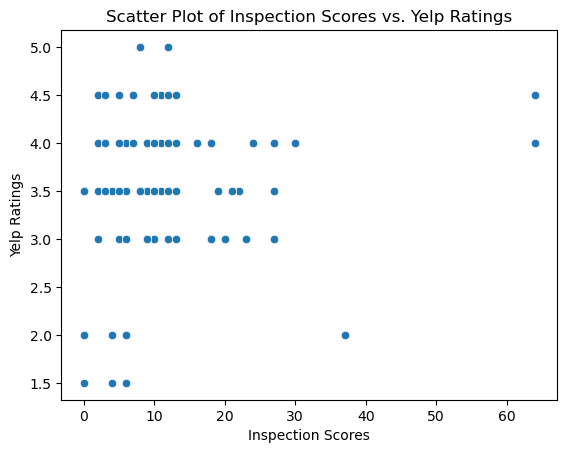

In [15]:
# Visualizing the correlation between 
sns.scatterplot(x=merged_df['SCORE'], y=merged_df['rating'])
plt.title('Scatter Plot of Inspection Scores vs. Yelp Ratings')
plt.xlabel('Inspection Scores')
plt.ylabel('Yelp Ratings')
plt.show()

## **Hypothesis Test 2:Try to find correlation between the inspection grades and the ratings on Yelp data**

In [16]:
# Remove rows with 'N', 'Z', and 'P' in the 'GRADE' column
# These letters signify: N = Not Yet Graded, Z = Grade Pending,
# P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure
merged_df = merged_df[~merged_df['GRADE'].isin(['N', 'Z', 'P'])]

In [17]:
# save list of columns needed for each group
#needed_col = ['GRADE', 'rating']

#merged_df[needed_col]

In [18]:
merged_df['rating'].value_counts()

3.5    177
4.0    171
3.0     40
4.5     37
2.0     11
5.0      5
1.5      3
Name: rating, dtype: int64

In [19]:
merged_df['GRADE'].value_counts()

A    331
B    102
C     11
Name: GRADE, dtype: int64

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 501
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CAMIS                  444 non-null    int64   
 1   DBA                    444 non-null    object  
 2   BORO                   444 non-null    object  
 3   BUILDING               444 non-null    object  
 4   STREET                 444 non-null    object  
 5   ZIPCODE                440 non-null    float64 
 6   CUISINE DESCRIPTION    444 non-null    object  
 7   INSPECTION DATE        444 non-null    object  
 8   ACTION                 444 non-null    object  
 9   VIOLATION CODE         444 non-null    object  
 10  VIOLATION DESCRIPTION  444 non-null    object  
 11  CRITICAL FLAG          444 non-null    object  
 12  SCORE                  444 non-null    float64 
 13  GRADE                  444 non-null    object  
 14  GRADE DATE             444 non-null    obj

In [21]:
print("Number of non-null values in 'GRADE':", merged_df['GRADE'].count())
print("Number of non-null values in 'rating':", merged_df['rating'].count())

Number of non-null values in 'GRADE': 444
Number of non-null values in 'rating': 444


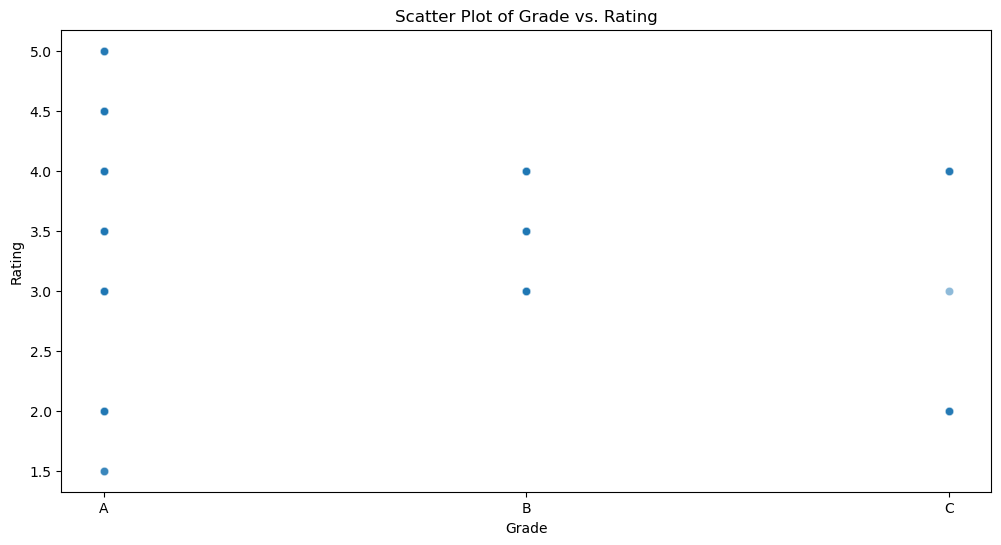

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GRADE', y='rating', data=merged_df, alpha=0.5)
plt.title('Scatter Plot of Grade vs. Rating')
plt.xlabel('Grade')
plt.ylabel('Rating')
plt.show()

In [23]:
# review_count_counts = merged_df['review_count'].value_counts().sort_values(ascending=False)
print(merged_df['review_count'])

0       459
1      2071
2      3074
3      1075
4       517
       ... 
497     120
498     297
499     297
500      54
501      54
Name: review_count, Length: 444, dtype: int64


In [24]:
review_count = merged_df['review_count']
rating = merged_df['rating']

# Calculate IQR
Q1 = review_count.quantile(0.25)
Q3 = review_count.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (review_count < Q1 - 1.5 * IQR) | (review_count > Q3 + 1.5 * IQR)

# Print outliers
print("Outliers:")
print(merged_df[outliers])

Outliers:
        CAMIS                        DBA      BORO BUILDING  \
1    50037645                JOE'S PIZZA  Brooklyn      216   
2    50037645                JOE'S PIZZA  Brooklyn      216   
3    50037645                JOE'S PIZZA  Brooklyn      216   
7    50084972                JOE'S PIZZA  Brooklyn      483   
8    50084972                JOE'S PIZZA  Brooklyn      483   
9    50084972                JOE'S PIZZA  Brooklyn      483   
13   50084972                JOE'S PIZZA  Brooklyn      483   
14   50084972                JOE'S PIZZA  Brooklyn      483   
15   50084972                JOE'S PIZZA  Brooklyn      483   
19   41349101                JOE'S PIZZA  Brooklyn      259   
20   41349101                JOE'S PIZZA  Brooklyn      259   
21   41349101                JOE'S PIZZA  Brooklyn      259   
25   50084972                JOE'S PIZZA  Brooklyn      483   
26   50084972                JOE'S PIZZA  Brooklyn      483   
27   50084972                JOE'S PIZZA  Bro

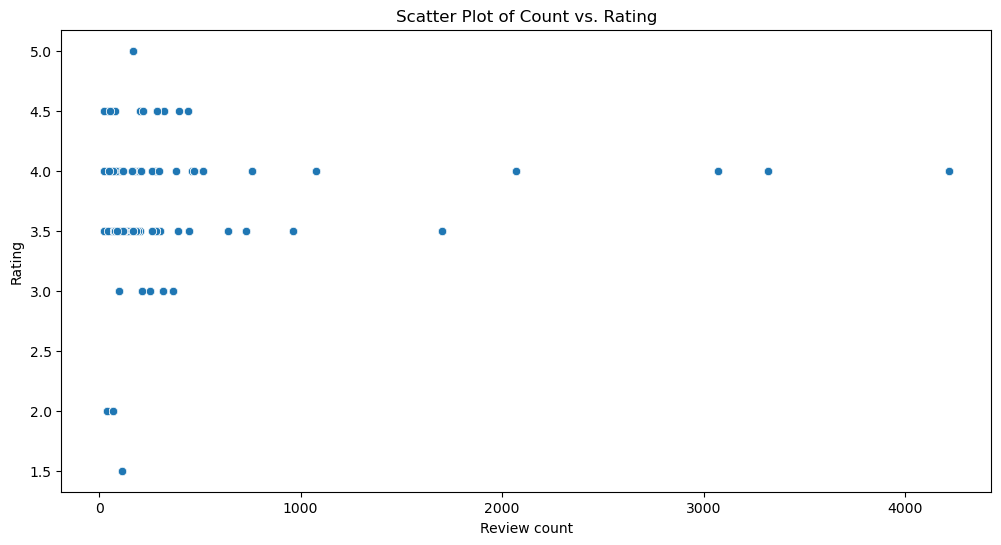

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='review_count', y='rating', data=merged_df)
plt.title('Scatter Plot of Count vs. Rating')
plt.xlabel('Review count')
plt.ylabel('Rating')
plt.show()

In [26]:
# Drop rows with NaN values if needed
original_length = len(merged_df)
merged_df = merged_df.dropna(subset=['GRADE', 'rating'])
new_length = len(merged_df)

print(f'Original length: {original_length}')
print(f'New length after dropping NaN values: {new_length}')

# Convert 'GRADE' column to numeric
merged_df['GRADE'] = pd.to_numeric(merged_df['GRADE'], errors='coerce')

# Convert 'rating' column to numeric
merged_df['rating'] = pd.to_numeric(merged_df['rating'], errors='coerce')

# Drop rows with infinite and NaN values in the 'rating' column
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rating'])

# Perform Pearson correlation test
if len(merged_df['GRADE']) < 2 or len(merged_df['rating']) < 2:
    print("Not enough data points to perform the correlation test.")
else:
    # Perform Pearson correlation test
    correlation, p_value = pearsonr(merged_df['GRADE'], merged_df['rating'])

    # Print results
    print(f'Correlation: {correlation:.2f}')
    print(f'P-value: {p_value:.4f}')

    # Check for significance based on the p-value
    if p_value < 0.05:
        print('The correlation is statistically significant.')
    else:
        print('There is no significant correlation.')


Original length: 444
New length after dropping NaN values: 444


ValueError: array must not contain infs or NaNs

## **Feature Engineering**

- Find out if there is a significant correlation between certain violations for certain restaurant types of specific areas/boros.

- Most common violations for each restaurant type and each set of chains if applicable for each boro.

- Do corporate restaurants or privately owned places get better scores/grades? What are the most common violations that cost the most points on the inspections.

- Construct predictive models to predict when initial and re-inspections are going to happen

- Construct predictive models to predict which restaurants will pass/fail inspections.

- Find out if there is correlation between a higher score/grade causing a restaurant to recive an overall better score on yelp. Look at the comparison between the results for coporate and privately owned places.